# SPH for the free-fall collapse problem

This code uses Smoothed Particle Hydrodynamics to perform the free-fall collapse of a Jupyter-like planet. Effects of pressure have also been added.

Credit: Eric Soriano & Guillem Ramirez 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pow

In [4]:
def generate_sphere(c, R, N, st):
    global pos;
    for i in range(N):
        x = R; y = R; z = R;
        while x**2 + y**2 + z**2 > R**2:
            x = np.random.uniform(-R, R) 
            y = np.random.uniform(-R, R) 
            z = np.random.uniform(-R, R) 
        pos[:, i+st] = np.array([x + c[0], y+ c[1], z + c[2]])
        
def generate_sphere_cub(c, R, n):
    global pos; global N;
    N2 = int(n*6/np.pi)
    positions = np.zeros([3, N2])
    N3 = N2**(1/3)
    lin = np.linspace(-R, R, N3)
    count = 0
    for x in lin:
        for y in lin:
            for z in lin:
                if x**2 + y**2 + z**2 <= R**2: 
                    positions[:, count] = np.array([x + c[0], y+ c[1], z + c[2]])
                    count +=1
    positions = positions[:, 0:count]
    N = count
    return positions

def norm(r1, r2):
    return np.sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2 + (r1[2]-r2[2])**2)

def new_ps():
    global pj; global pos; global p; global P; global N
    for i in range(N):
        for j in range(i, N):
            rk = m/2*(ker(norm(pos[:, i], pos[:, j]), i) + ker(norm(pos[:, i], pos[:, j]), j))
            pj[i][j] = pj[j][i] = rk
    p = np.sum(pj, axis=0)
    P = (R_g*T/mu)*p
    
def new_h(i):
    global h; global p
    return h[i]/(np.sum(p))**(1/3)

def ker(r, i):
    global h
    lam=r/h[i]
    if lam<=2 and lam>1: 
        return 1/4*((2-lam)**3)/(np.pi*(h[i]**3))
    elif lam>2: 
        return 0 
    return (1-3/2*(lam**2)+3/4*(lam**3))/(np.pi*(h[i]**3))

def Fn():
    global pos; global m; global eps; global N; global norms
    f = np.zeros([3, N])
    for i in range(N):
        for j in range(i+1, N):
            r = norm(pos[:,i], pos[:, j])
            norms[i][j] = norms[j][i] = r
            u=r/eps
            if u<1:
                a=m/(eps**3)*(4/3-(6/5)*(u**2)+(1/2)*(u**3))*(pos[:, j]-pos[:, i])
            elif u<2:
                a=m/(r**3)*(-1/15 + (8/3)*(u**3)-3*(u**4)+(6/5)*(u**5)-1/6*(u**6))*(pos[:, j]-pos[:, i])
            else:
                a=m*(pos[:, j]-pos[:, i])/(r**3)
            f[:, i] += G*a
            f[:, j] -= G*a   
    return f

def gradker(r, rj, i):
    global h
    r=r-rj
    R=norm(r, rj)
    lam=R/h[i]
    x=r[0]; y=r[1]; z=r[2]
    gradient=np.array([x, y, z])
    if lam<=2 and lam>1: 
        aux = 3/4*((2-lam)**2)*(-1/h[i])/(R*np.pi*(h[i]**3))
        return aux*gradient
    elif lam>2: 
        return 0 
    aux=(-3/(h[i]**2)+9/4*lam/h[i])/(np.pi*(h[i]**3))
    return aux*gradient

#speed sound
def v_pis(i, j):
    global p; global pos; global vel; global N; global c; global h;
    alpha=1
    beta=2
    nu=0.01
    pij=(p[j]+p[i])/2
    mu=0
    ht=(h[i]+h[j])/2
    r=pos[:, i]-pos[:, j]
    v=vel[:, i]-vel[:, j]
    if(np.dot(r, v)<0):
        mu=np.dot(r, v)/(ht*((r/ht)**2+nu))
    return (-alpha*mu*cs+beta*(mu**2))/pij

def visco_P():
    global P; global p; global pos; global N; global m
    ret = np.zeros([3, N])
    for i in range(N):
        for j in range(i+1, N):
            v_pi=v_pis(i,j)
            b=1e9*m*(2*np.sqrt(P[j]*P[i])/(p[j]*p[i])+v_pi)*1/2*(gradker(pos[:, i], pos[:, j], i) + gradker(pos[:, i], pos[:, j], j))
            ret[:, i] += b
            ret[:, j] -= b
    return ret

Iteration loop

In [7]:
#inici
#variables en cgs
R_0 = 7e9 #radi
d_0 = 1.3 #densitat
N = 1000 #nombre de particules AJUSTAR
M =  4/3*np.pi*d_0*(R_0)**3 #massa total
m = M/N #massa per particula
G = 6.674e-8 #constant de gravitacio
tol = 1e-4
n = 20 #iteracions AJUSTAR

R_g = 8.314e7
mu = 2.7
T = 22000 #temperatura
nv = 50 #nombre desitjat de veins

tf = 1000 #temps final AJUSTAR
t = tf/n

pos = np.zeros([3, N])
vel = np.zeros([3, N])

generate_sphere([-5*R_0, 0, 0], R_0, N//2, 0)
generate_sphere([5*R_0, 0, 0], R_0, N//2, N//2)
#pos = generate_sphere_cub([0, 0, 0], R_0, 3500)

for i in range(N//2):
    vel[:, i] = np.array([R_0/40, 0, 0])
    vel[:, i+ N//2] = np.array([-R_0/40, 0, 0])

pj = np.zeros([N, N])
p = np.zeros([N])
P = np.zeros([N])
cs = np.sqrt(R_g*T/mu)
norms = np.zeros([N, N])

h_0 = R_0/800 #A AJUSTAR
h = h_0*10*np.ones(N)
eps = h_0

frames = np.zeros([n+1, 3, N])
temps = [0]
frames[0] = pos
v = np.zeros(N)
radis = np.zeros([n, N])

#bucle
for i in tqdm(range(n)):
    new_ps()
    f = Fn()
    visP = visco_P()
    ratio = len(np.where((np.sum(visP**2, axis = 0)-np.sum(f**2, axis = 0)) > 0)[0])/N*100
    print('Dominancia viscP sobre gravetat en %:', ratio)
    temps.append(temps[-1]+t)
    for j, l in enumerate(norms):
        v[j] = len(np.where(l<= h)[0]) - 1
    #h = [h[j]/2*(1+(nv/max(1,v[i]))**(1/3)) for j in range(N)]
    print ('veins:', np.mean(v))
    #eps = np.mean(h)
    #print('eps:', eps)
    pos += t*vel
    vel += t*(-visP + f)
    #fname = 'pos_'+str(i)+'.txt'
    #np.savetxt(fname, pos)
    cuad = pos**2
    radis[i] = np.sort(np.sqrt(cuad[0] +cuad[1] +cuad[2]))
    print('median radi:', np.median(radis[i]))
    frames[i+1] = pos

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

Do the graph to see the compression

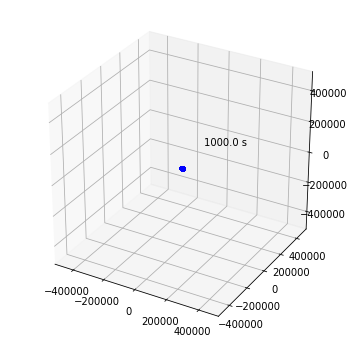

In [19]:
from mpl_toolkits import mplot3d
#pos = generate_sphere(2500, 1)
R_0 = 1e5
n = 10
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-5*R_0, 5*R_0)
ax.set_ylim3d(-5*R_0, 5*R_0)
ax.set_zlim3d(-5*R_0, 5*R_0)
ax.scatter3D(frames[n][0], frames[n][1], frames[n][2], c='blue')
ax.text(0.7*R_0, 1.1*R_0, 1.2*R_0, str("{0:.1f}".format(temps[n]))+' s', color='black')
#ax.scatter3D(y[0], y[1], y[2], c='red')
#ax.scatter3D(trajectoria[0], trajectoria[1], trajectoria[2], c='green')
plt.show()

Graph for different moments

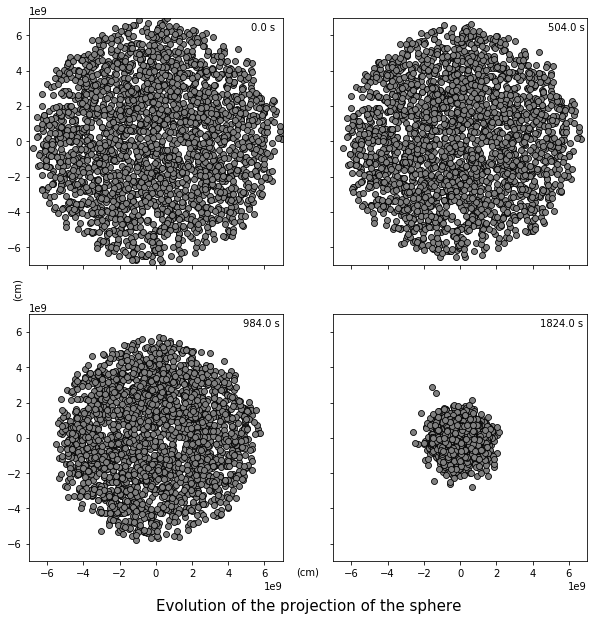

In [145]:
from mpl_toolkits import mplot3d
#pos = generate_sphere(2500, 1)
t1 = 0; t2 = 20; t3 = 40; t4 = 75;
R_0 = 7e9
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize= [10, 10])
ax1.scatter(frames[t1][0], frames[t1][1], color = 'grey', edgecolors='black', linewidths=0.8, label= str(temps[t1])+' s')
ax1.set_xlim(-R_0, R_0)
ax1.set_ylim(-R_0, R_0)
ax1.text(0.75*R_0, 0.9*R_0, '0.0 s', color='black')
ax2.scatter(frames[t2][0], frames[t2][1], color = 'grey', edgecolors='black', linewidths=0.8, label= str(temps[t1])+' s')
ax2.set_xlim(-R_0, R_0)
ax2.set_ylim(-R_0, R_0)
ax2.text(0.69*R_0, 0.9*R_0, str("{0:.1f}".format(temps[t2])) +' s', color='black')
ax3.scatter(frames[t3][0], frames[t3][1], color = 'grey', edgecolors='black', linewidths=0.8, label= str(temps[t1])+' s')
ax3.set_xlim(-R_0, R_0)
ax3.set_ylim(-R_0, R_0)
ax3.text(0.69*R_0, 0.9*R_0, str("{0:.1f}".format(temps[t3])) +' s', color='black')
ax4.scatter(frames[t4][0], frames[t4][1], color = 'grey', edgecolors='black', linewidths=0.8, label= str(temps[t1])+' s')
ax4.set_xlim(-R_0, R_0)
ax4.set_ylim(-R_0, R_0)
ax4.text(0.63*R_0, 0.9*R_0, str("{0:.1f}".format(temps[t4])) +' s', color='black')
ax3.set_xlabel('(cm)', fontsize = 10)
ax3.xaxis.set_label_coords(1.10, -0.025)
ax3.set_ylabel('(cm)', fontsize = 10)
ax3.yaxis.set_label_coords(-0.025, 1.10)
ax3.text(0, -1.4*R_0, 'Evolution of the projection of the sphere', color='black', fontsize = 15)
plt.savefig("Evolution.png")

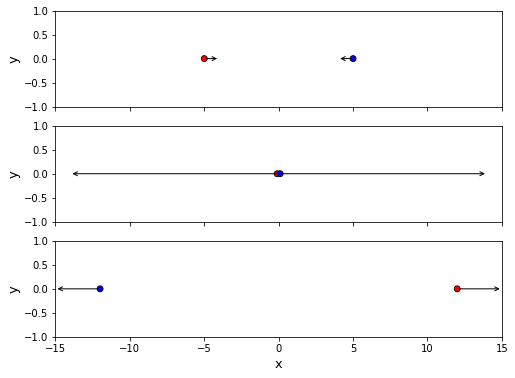

In [2]:
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize= [8, 6])
ax1.scatter([-5, 5], [0, 0], color = ['red', 'blue'], edgecolors='black', linewidths=0.8, label= 't1')
ax1.set_xlim(-15, 15)
ax1.set_ylim(-1, 1)
#ax1.text(0.75*R_0, 0.9*R_0, '0.0 s', color='black')
ax2.scatter([-0.1, 0.1], [0, 0], color = ['red', 'blue'], edgecolors='black', linewidths=0.8, label= 't2')
ax2.set_xlim(-15, 15)
ax2.set_ylim(-1, 1)
#.text(0.69*R_0, 0.9*R_0, str("{0:.1f}".format(temps[t2])) +' s', color='black')
ax3.scatter([12, -12], [0, 0], color = ['red', 'blue'], edgecolors='black', linewidths=0.8, label= 't3')
ax3.set_xlim(-15, 15)
ax3.set_ylim(-1, 1)
ax3.set_xlabel('x', fontsize = 13)
ax1.set_ylabel('y', fontsize = 13)
ax2.set_ylabel('y', fontsize = 13)
ax3.set_ylabel('y', fontsize = 13)
ax1.annotate("", xy=(-4, 0), xytext=(-5, 0), arrowprops=dict(arrowstyle="->"), color ='r')
ax1.annotate("", xy=(4, 0), xytext=(5, 0), arrowprops=dict(arrowstyle="->"))
ax2.annotate("", xy=(14, 0), xytext=(-0.1, 0), arrowprops=dict(arrowstyle="->"))
ax2.annotate("", xy=(-14, 0), xytext=(0.1, 0), arrowprops=dict(arrowstyle="->"))
ax3.annotate("", xy=(-15, 0), xytext=(-12, 0), arrowprops=dict(arrowstyle="->"))
ax3.annotate("", xy=(15, 0), xytext=(12, 0), arrowprops=dict(arrowstyle="->"))

plt.savefig('creuen.png')
#ax3.text(0.69*R_0, 0.9*R_0, str("{0:.1f}".format(temps[t3])) +' s', color='black')
#ax3.text(0, -1.4*R_0, 'Evolution of the projection of the sphere', color='black', fontsize = 15)

In [50]:
##LECTURA

frames = []
for i in range(100):
    fname = 'visc2/pos_'+str(i)+'.txt'
    f = np.loadtxt(fname)
    frames.append(f)
print(len(frames))
temps = np.linspace(0, 2400, 101)
temps = temps[1:]
radis = np.zeros([len(frames), len(frames[0][0])])
for i, pos in enumerate(frames):
    cuad = pos**2
    radis[i] = np.sort(np.sqrt(cuad[0] +cuad[1] +cuad[2]))

100


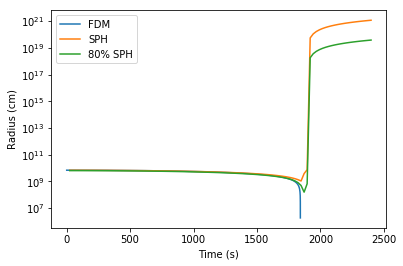

In [53]:
n = 100
nf = 900
tf = temps[-1]
nlim = [int(999+ (nf-999)*i*2000/(tf*n)) for i in range(n)]
perc = 80


qvs = []
for i in range(100):
    el = np.where(radis[0, :-1] == np.percentile(radis[0, :-1], perc, interpolation='lower'))[0][0]
    qvs.append(el)
qvs = [[range(100)], qvs]

vol = np.loadtxt('test.txt')
plt.semilogy(vol[:, 0], vol[:, 1], basey= 10, label = 'FDM')
#.axhline(y=7e7, color='r')
rad = []
for j in range(n):
    rad.append(radis[j][nlim[j]])
plt.semilogy(temps, radis[:,-1], basey = 10, label = 'SPH')
#plt.semilogy(temps, pol, basey = 10, label = 'sph_freefall')
a = radis[qvs][0]
plt.semilogy(temps,a, basey = 10, label = str(perc)+'% SPH')
plt.xlabel('Time (s)')
plt.ylabel('Radius (cm)')
plt.legend()
plt.savefig('radius.png')
#plt.show()

In [18]:
pol = radis[:, -1]

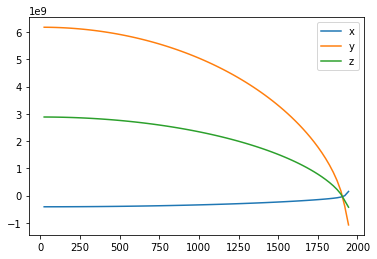

In [8]:
tfinal = 81
plt.plot(temps[:tfinal],np.array(frames)[:tfinal,0, 1255], label = 'x')
plt.plot(temps[:tfinal],np.array(frames)[:tfinal,1, 1255], label = 'y')
plt.plot(temps[:tfinal],np.array(frames)[:tfinal,2, 1255], label = 'z')
plt.legend()
plt.show()

Alternative geometries

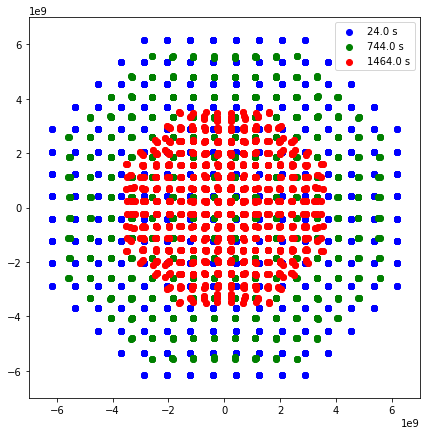

In [12]:
fig = plt.figure(figsize=(7, 7))
R_0 = 7e9
ax = plt.axes()
ax.set_xlim(-R_0, R_0)
ax.set_ylim(-R_0, R_0)
t1 = 0; t2 = 30; t3 = 60
plt.scatter(frames[t1][0], frames[t1][1], color = 'b', label= str(temps[t1])+' s')
plt.scatter(frames[t2][0], frames[t2][1], color = 'g', label= str(temps[t2])+' s')
plt.scatter(frames[t3][0], frames[t3][1], color = 'r', label= str(temps[t3])+' s')
plt.legend()
plt.show()

In [54]:
from mpl_toolkits import mplot3d
def frame(num):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax.set_xlim3d(-R_0, R_0)
    ax.set_ylim3d(-R_0, R_0)
    ax.set_zlim3d(-R_0, R_0)
    ax.scatter3D(frames[i][0], frames[i][1], frames[i][2], c='blue')
    ax.text(0.7*R_0, 1.1*R_0, 1.2*R_0, str("{0:.1f}".format(temps[num]))+' s', color='black')
    plt.savefig("data_200/esfera_nopressio_"+str(num)+".png")
    plt.figure(figsize=(200,200))
    plt.close('all')

R_0 = 1e21
for i in range(0, 100):
    if i%2 == 0: continue
    frame(i)

In [32]:
pos = np.array([[-1e5, 1e5], [0, 0],[0, 0]])
vel = np.array([[0., 0.], [0., 0.],[0., 0.]])
N= 2
m = 1e20
cols = []
n = 10
temps = [0]
for i in tqdm(range(n)):
    t = 100
    f = Fn()
    pos += t*vel
    vel += t*f
    cols.append(pos)
    temps.append(temps[-1]+t)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10000.72it/s]


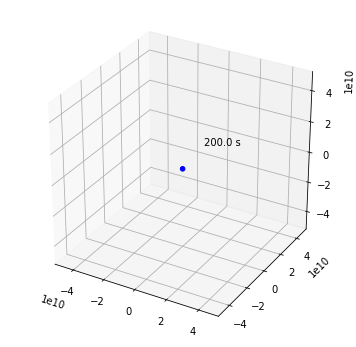

In [35]:
from mpl_toolkits import mplot3d
#pos = generate_sphere(2500, 1)
R_0 = 10e9
n = 4
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-5*R_0, 5*R_0)
ax.set_ylim3d(-5*R_0, 5*R_0)
ax.set_zlim3d(-5*R_0, 5*R_0)
ax.scatter3D(cols[n][0], cols[n][1], cols[n][2], c='blue')
ax.text(0.7*R_0, 1.1*R_0, 1.2*R_0, str("{0:.1f}".format(temps[n]))+' s', color='black')
#ax.scatter3D(y[0], y[1], y[2], c='red')
#ax.scatter3D(trajectoria[0], trajectoria[1], trajectoria[2], c='green')
plt.show()